In [16]:
library(dplyr)
library(tidyverse)
library(magrittr)

Warning message:
“package ‘magrittr’ was built under R version 4.2.3”

Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract




In [5]:
diffgene = read.csv('./3.enrichment/count.csv_Final_Out.csv',row.names = 1)

In [6]:
colnames(diffgene)

[1] "KO.CLPvsWT.CLP_.logFC."  "KO.CLPvsWT.CLP_.pvalue."
 [3] "KO.CLPvsWT.CLP_.Qvalue." "KO.NCvsWT.NC_.logFC."   
 [5] "KO.NCvsWT.NC_.pvalue."   "KO.NCvsWT.NC_.Qvalue."  
 [7] "WT.CLPvsWT.NC_.logFC."   "WT.CLPvsWT.NC_.pvalue." 
 [9] "WT.CLPvsWT.NC_.Qvalue."  "KO.CLPvsKO.NC_.logFC."  
[11] "KO.CLPvsKO.NC_.pvalue."  "KO.CLPvsKO.NC_.Qvalue."

In [12]:
fc = diffgene %>% dplyr::select(contains('logFC'))
pvalue = diffgene %>% dplyr::select(contains('pvalue'))

In [23]:
fc1 = rownames_to_column(fc, var = "gene")

In [25]:
pvalue1 = rownames_to_column(pvalue, var = "gene")

In [26]:
fc.long <- pivot_longer(fc1,cols = -gene, 
                         names_to = "group", 
                         values_to = "logFC")

In [28]:
pvalue.long <- pivot_longer(pvalue1,cols = -gene, 
                         names_to = "group", 
                         values_to = "pvalue")

In [29]:
head(pvalue.long)

gene,group,pvalue
<chr>,<chr>,<dbl>
WT-NC8.dna_NODE_548486_length_134_cov_4.714286_1,KO.CLPvsWT.CLP_.pvalue.,0.6428325
WT-NC8.dna_NODE_548486_length_134_cov_4.714286_1,KO.NCvsWT.NC_.pvalue.,0.4884651
WT-NC8.dna_NODE_548486_length_134_cov_4.714286_1,WT.CLPvsWT.NC_.pvalue.,0.9457345
WT-NC8.dna_NODE_548486_length_134_cov_4.714286_1,KO.CLPvsKO.NC_.pvalue.,0.4286858
WT-NC8.dna_NODE_548322_length_140_cov_3.076923_1,KO.CLPvsWT.CLP_.pvalue.,0.5587324
WT-NC8.dna_NODE_548322_length_140_cov_3.076923_1,KO.NCvsWT.NC_.pvalue.,0.7614491


In [62]:
data = cbind(pvalue.long,fc.long[,3])

In [63]:
data$group = gsub('_.pvalue.','',data$group)

In [64]:
colnames(data)

[1] "gene"   "group"  "pvalue" "logFC"

In [65]:
data = data %>% filter(pvalue < 0.05)

In [66]:
data <- data %>%mutate(type = ifelse(logFC >=0,"Up","Down"))%>%
mutate(type2 = ifelse(pvalue < 0.01,"aPvalue < 0.01","Pvalue >= 0.01"))

In [67]:
min(data$logFC)

[1] -22.9358

In [68]:
data$type = factor(data$type,levels=c('Up','Down'))

In [119]:
p = ggplot(data, aes(group, logFC)) +
geom_jitter(aes(color = type))

In [73]:
cell <-unique(data$group)

In [74]:
cell

[1] "KO.CLPvsKO.NC"  "KO.CLPvsWT.CLP" "WT.CLPvsWT.NC"  "KO.NCvsWT.NC"

In [78]:

back.data<- data.frame()
for(n in 1:length(cell)){
tmp <- data %>%filter(group==cell[n])
new.tmp <- data.frame(group = cell[n],min=min(tmp$logFC) - 0.2,max = max(tmp$logFC) + 0.2)
back.data <- rbind(back.data,new.tmp)}

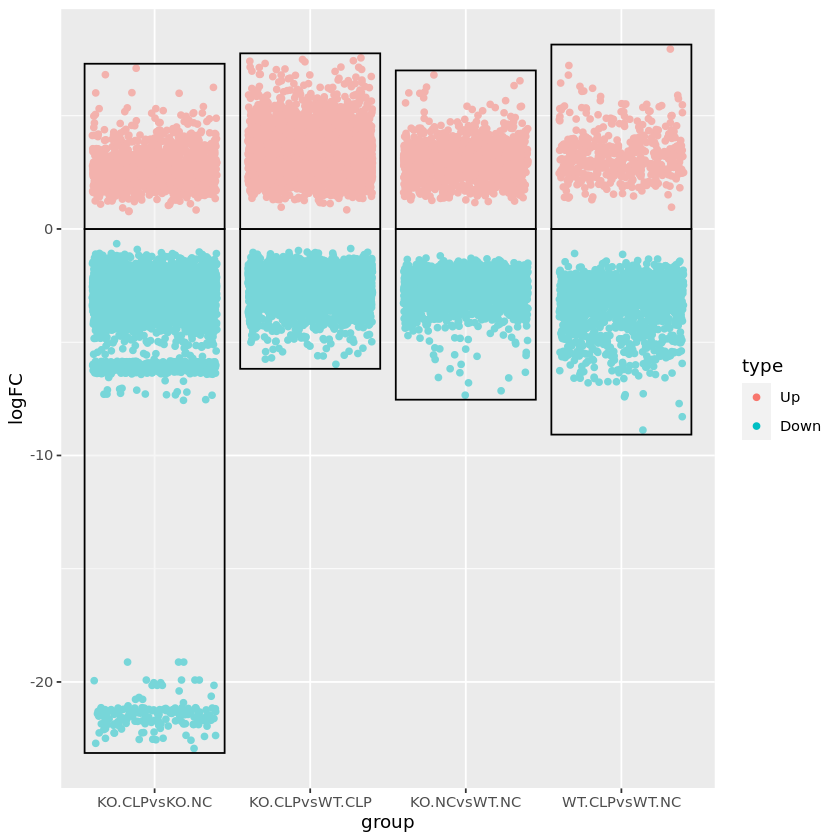

In [81]:
ggplot(data, aes(group, logFC)) +
geom_jitter(aes(color = type)) +
geom_col(data = back.data,aes(x = group,y = min),fill="grey93",color="black",alpha=0.5) +
geom_col(data = back.data,aes(x = group,y = max),fill="grey93",color="black",alpha=0.5)

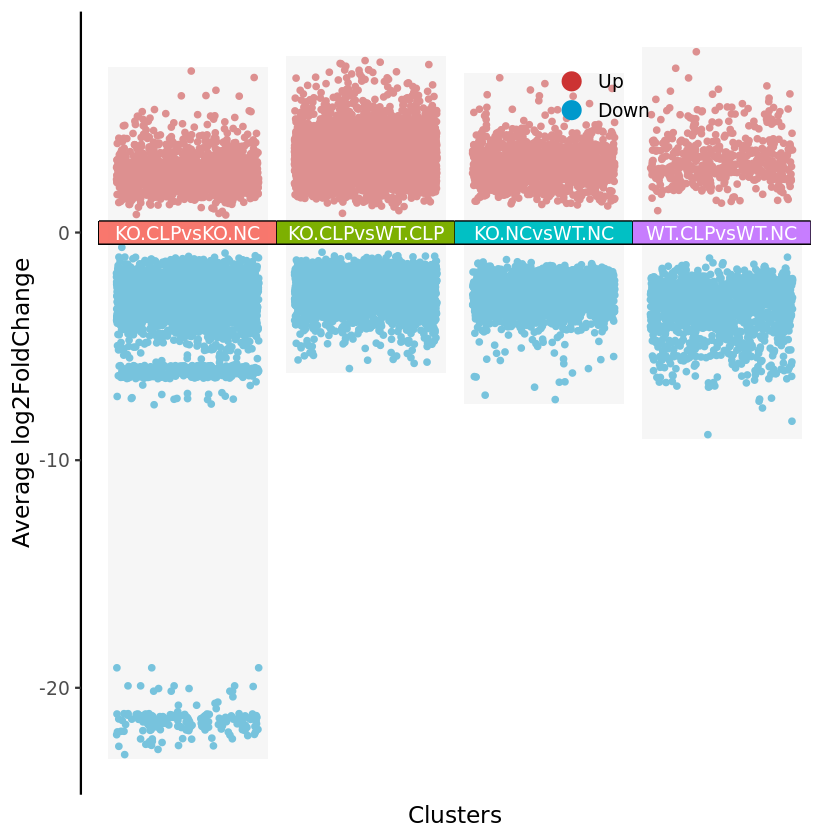

In [116]:
ggplot(data, aes(group, logFC)) +
geom_jitter(aes(color = type)) +
geom_col(data = back.data,aes(x = group,y = min),fill="grey93",alpha=0.5) +
geom_col(data = back.data,aes(x = group,y = max),fill="grey93",alpha=0.5) +
scale_color_manual(values=c(Down="#0099CC",Up="#CC3333"))+
theme_classic(base_size = 14) +
theme(panel.grid = element_blank(),
legend.position = c(0.7,0.9),
legend.title = element_blank(),
legend.background = element_blank()) +
xlab('Clusters') + ylab('Average log2FoldChange') +
guides(color = guide_legend(override.aes = list(size = 5)))+
geom_tile(aes(x = group,y = 0,fill = group),color = 'black',height = 1,alpha = 0.3,show.legend = F)+
geom_text(data=back.data,aes(x = group,y = 0,label = group),size=4,color="white") +
theme(axis.line.x = element_blank(),
axis.text.x = element_blank(),
axis.ticks.x = element_blank())

In [117]:
outdir = './3.enrichment'

In [118]:
ggsave(file = paste0(outdir,'/','diffgene.pdf'),width = 6,height = 5)
ggsave(file = paste0(outdir,'/','diffgene.png'),width = 6,height = 5)

In [94]:
df = data[,c(1,2,4)]

In [105]:
data1 <- subset(df, df$logFC > 0)
data2 <- subset(df, df$logFC < 0)

In [106]:
data1$logFC <-NULL
data2$logFC <-NULL

In [107]:
dt1 <- as.data.frame(table(data1$group))
dt1$sig <- 'Up-regulation'
dt2 <- as.data.frame(table(data2$group))
dt2$Freq <- -(dt2$Freq)
dt2$sig <- 'Down-regulation'

In [112]:
p <- ggplot() + theme_bw()+
  geom_bar(data = dt1, aes(x=Var1, y=Freq, fill=sig),stat = "identity",position = 'dodge') +
  geom_text(data = dt1, aes(x=Var1,  y=Freq, label=Freq, vjust=-0.25))+
 geom_bar(data = dt2, aes(x=Var1, y=Freq, fill=sig),stat = "identity",position = 'dodge') +
  geom_text(data = dt2, aes(x=Var1,  y=Freq, label=Freq, vjust=-0.25))+
  scale_fill_manual(values=c("#0072B5","#BC3C28"))+
  theme(axis.text.x = element_text(angle = 45, hjust = 0.5, vjust=0.5))+xlab('')+ylab('')

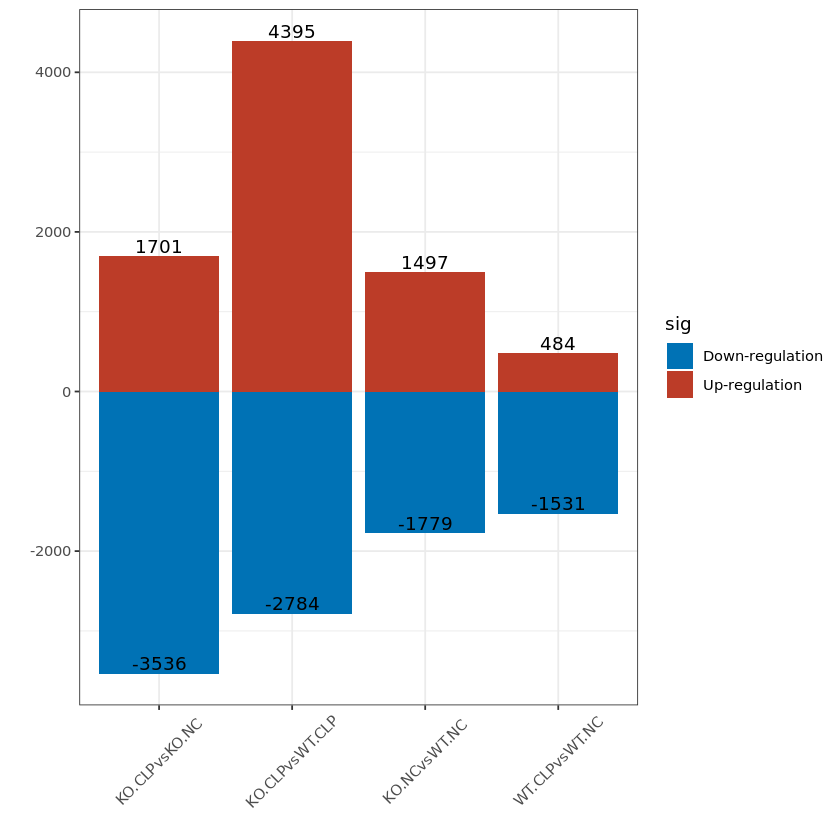

In [113]:
p

In [114]:
ggsave(file = paste0(outdir,'/','diffgene_number.pdf'),width = 6,height = 5)
ggsave(file = paste0(outdir,'/','diffgene_number.png'),width = 6,height = 5)